In [1]:
import argparse
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import sys

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as tf

from mypath import Path
from dataloaders import aicup
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator

import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

In [2]:
# Check your device
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [3]:
# Model initialization
num_class=2
model = DeepLab(num_classes=num_class,
                backbone='resnet',
                output_stride=16,
                sync_bn=None,
                freeze_bn=False)

In [4]:
# Put model to GPU (or cpu)
model = nn.DataParallel(model).to(DEVICE)

In [5]:
# Load model checkpoint
checkpoint = torch.load('./run/aicup/deeplab-resnet/experiment_0/checkpoint.pth.tar')
model.module.load_state_dict(checkpoint['state_dict'])
checkpoint['best_pred']

0.9685401596337008

In [6]:
def eval_one_training_image(model, img_name='DSC080454', num_class=2, \
                            crop_size=(513,513), crop_origin=(0,0)):
    
    # ---------------------------- Start data preparing ------------------------------ #
    # Load image & ground truth label
    image = Image.open('../data/Train_Dev/training/'+img_name+'.JPG').convert('RGB')
    _points = pd.read_csv('../data/Train_Dev/train_labels/'+img_name+'.csv', header=None).to_numpy()

    print('Original image size = ',image.size)
    
    # Parameters that determines size&shape of visualized points
    ########### CAN BE MODIFIED AS YOU LIKE #########
    _range = 10
    _dis=10
    
    # Initial label array & array for visualizing label
    label = np.zeros(image.size)
    visualized_label = np.zeros(image.size)
    for (x, y) in _points:
        label[x, y] = 1. # Put 1 wherever ther ground truth are
        for i in range(-_range, _range):
               for j in range(-_range, _range):
                    # Check if out-of-bound & make sure the point to be print is circle
                    if x+i >= label.shape[0] or y+j >= label.shape[1] or x+i<0 or y+j<0 \
                        or (i**2+j**2)**0.5 > _dis:
                        continue
                    visualized_label[x+i, y+j] = 1.

    label = np.transpose(label)
    visualized_label = np.transpose(visualized_label)

    label = Image.fromarray(np.uint8(label*255))
    visualized_label = Image.fromarray(np.uint8(visualized_label*255))
    
    
    # Crop image & label from crop_origin by crop_size    
    w, h = image.size
    assert w >= crop_origin[0] and h >= crop_origin[1] and crop_origin[0] >= 0 and crop_origin[1] >=0,\
            'Origin point out of image bound!'
    assert w >= crop_origin[0]+crop_size[0] and h >= crop_origin[1]+crop_size[1], \
            'Crop region out of image bound!'
    
    x1, y1 = crop_origin
    x2, y2 = x1+crop_size[0], y1+crop_size[1]
    image = image.crop((x1, y1, x2, y2))
    print('Input image size = ', image.size)
    label = label.crop((x1, y1, x2, y2))
    visualized_label = visualized_label.crop((x1, y1, x2, y2))
    
    image = np.array(image)
    plt.figure()
    plt.imshow(image)
    plt.title('Input image')
    plt.show()
    
    plt.figure()
    plt.imshow(visualized_label)
    plt.title('Ground truth label')
    plt.show()
    
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)

    image = image.astype(np.float32)
    image /= 255.0
    image -= mean
    image /= std
    
    tensor_image = torch.unsqueeze(tf.ToTensor()(image).to(DEVICE), 0)
    tensor_label = torch.unsqueeze(tf.ToTensor()(label).to(DEVICE), 0)
    
    # ---------------------------- End data preparing ------------------------------ #
    # Initial evaluator
    evaluator = Evaluator(num_class)
    
    # Model evaluation
    model.eval()
    output = model(tensor_image)
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    target = np.squeeze(tensor_label.cpu().numpy())
    plt.figure()
    plt.imshow(pred[0])
    plt.title('Model Prediction')
    plt.show()
    
    # Print evaluation info
    evaluator.reset()
    evaluator.add_batch(target, pred[0])
    print('Class-averaging accuracy = ', evaluator.Pixel_Accuracy_Class())
    np.set_printoptions(suppress=True)
    print('Confusion matrix: ')
    print(evaluator.confusion_matrix)
    
    return np.transpose(np.nonzero(pred[0])), np.transpose(np.nonzero(target))

In [7]:
def eval_one_testing_image(model, img_name='DSC080454', num_class=2, \
                            crop_size=(513,513), crop_origin=(0,0), test_folder='test_public'):
    
    # ---------------------------- Start data preparing ------------------------------ #
    # Load image & ground truth label
    image = Image.open(os.path.join('../data/',test_folder,img_name+'.JPG')).convert('RGB')

    print('Original image size = ',image.size)
    
    
    # Crop image & label from crop_origin by crop_size    
    w, h = image.size
    assert w >= crop_origin[0] and h >= crop_origin[1] and crop_origin[0] >= 0 and crop_origin[1] >=0,\
            'Origin point out of image bound!'
    assert w >= crop_origin[0]+crop_size[0] and h >= crop_origin[1]+crop_size[1], \
            'Crop region out of image bound!'
    
    x1, y1 = crop_origin
    x2, y2 = x1+crop_size[0], y1+crop_size[1]
    image = image.crop((x1, y1, x2, y2))
    print('Input image size = ', image.size)
    
    image = np.array(image)
    plt.figure()
    plt.imshow(image)
    plt.title('Input image')
    plt.show()
    
    mean=(0.485, 0.456, 0.406)
    std=(0.229, 0.224, 0.225)

    image = image.astype(np.float32)
    image /= 255.0
    image -= mean
    image /= std
    
    tensor_image = torch.unsqueeze(tf.ToTensor()(image).to(DEVICE), 0)
    
    # ---------------------------- End data preparing ------------------------------ #
    # Model evaluation
    model.eval()
    output = model(tensor_image)
    pred = output.data.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    plt.figure()
    plt.imshow(pred[0])
    plt.title('Model Prediction')
    plt.show()
    
    return np.transpose(np.nonzero(pred[0]))

In [8]:
def eval_whole_training_set(model, base_size=1024, crop_size=513):
    # Data preprocess
    # Use a temporary object ; just to match dataloaders' parameters
    class tmp_obj():
        def __init__(self):
            self.task = 'segmentation'
            self.base_size=base_size
            self.crop_size=crop_size
    args = tmp_obj()
    
    # Prepare dataloader
    train_set = aicup.AICUPDataset(args, split='Train_Dev')
    num_class = train_set.NUM_CLASSES if args.task=='segmentation' else 1
    train_loader = DataLoader(train_set, batch_size=4, shuffle=False, num_workers=4)
    
    # Initial evaluator
    evaluator = Evaluator(num_class)
    
    
    model.eval()
    evaluator.reset()
    for i, sample in enumerate(train_loader):
        image, target = sample['image'].to(DEVICE), sample['label'].to(DEVICE)
        output = model(image)
        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred)
    print('Class-averaging accuracy = ', evaluator.Pixel_Accuracy_Class())
    np.set_printoptions(suppress=True)
    print('Confusion matrix: ')
    print(evaluator.confusion_matrix)

In [9]:
# Use a temporary object ; just to match dataloaders' parameters
class tmp_obj():
    def __init__(self):
        self.task = 'segmentation'
        self.base_size=1024
        self.crop_size=513
args = tmp_obj()

## How To Run?
### You have 3 choices:

### 1. Predict 1 image

In [11]:
# List all images
_img_names = sorted(os.listdir('../data/Train_Dev/training/'))
for i, _img in enumerate(_img_names):
    _img_names[i] = _img[:-4]
print('img_name in training dataset ; You can choose any of them')
print(_img_names)

img_name in training dataset ; You can choose any of them
['DSC080454', 'DSC080552', 'DSC080694', 'DSC080814', 'DSC080993', 'DSC081022', 'DSC081093', 'DSC081101', 'DSC081104', 'DSC081272', 'DSC081541', 'DSC081681', 'DSC081682', 'DSC081693', 'DSC081721', 'DSC081724', 'DSC081871', 'DSC082112', 'DSC082123', 'DSC082144', 'DSC082151', 'DSC082451', 'DSC082761', 'DSC082764', 'DSC082791', 'IMG_170406_035932_0022_RGB4', 'IMG_170406_035933_0023_RGB3', 'IMG_170406_035939_0028_RGB3', 'IMG_170406_040009_0053_RGB1', 'IMG_170406_040033_0073_RGB2', 'IMG_170406_040105_0099_RGB4', 'IMG_170406_040108_0102_RGB3', 'IMG_170406_040108_0102_RGB4', 'IMG_170406_040156_0142_RGB1', 'IMG_170406_040202_0147_RGB3', 'IMG_170406_040202_0147_RGB4', 'IMG_170406_040308_0202_RGB1', 'IMG_170406_040351_0238_RGB4', 'IMG_170406_040353_0239_RGB2', 'IMG_170406_040354_0240_RGB4', 'IMG_170406_040355_0241_RGB4', 'IMG_170406_040356_0242_RGB2', 'IMG_170406_040408_0252_RGB2', 'IMG_170406_040409_0253_RGB3']


Original image size =  (3000, 2000)
Input image size =  (513, 513)


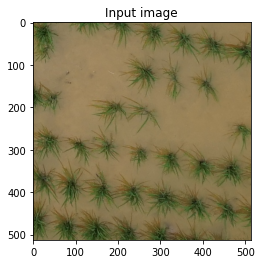

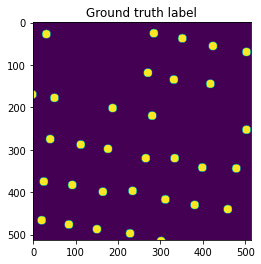

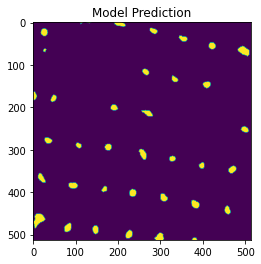

Class-averaging accuracy =  0.9858800861901884
Confusion matrix: 
[[255708.   7431.]
 [     0.     30.]]


In [12]:
## Uncomment this to evaluate 1 training image
prediction, ground_truth = eval_one_training_image(model, img_name=_img_names[0], num_class=2,\
                                                   crop_size=(513, 513), crop_origin=(513, 513))

### 2. Evaluate whole training dataset

In [13]:
eval_whole_training_set(model, base_size=1024, crop_size=513)

Number of images in Train_Dev: 44
Class-averaging accuracy =  0.9600899682411892
Confusion matrix: 
[[11156967.   419783.]
 [     117.     2569.]]


### 3. Generate 1 testing result

In [14]:
test_folder = 'test_public' # can be 'test_public' or 'test_private'
# List all images
_img_names = sorted(os.listdir('../data/'+test_folder))
for i, _img in enumerate(_img_names):
    _img_names[i] = _img[:-4]
print('img_name in training dataset ; You can choose any of them')
print(_img_names)

img_name in training dataset ; You can choose any of them
['DSC080633', 'DSC080733', 'DSC080823', 'DSC080994', 'DSC081024', 'DSC081034', 'DSC081133', 'DSC081152', 'DSC081433', 'DSC081494', 'DSC081543', 'DSC081723', 'DSC082013', 'DSC082111', 'DSC082113', 'DSC082121', 'DSC082124', 'DSC082143', 'DSC082153', 'DSC082453', 'DSC082454', 'DSC082754', 'DSC082762', 'DSC082781', 'DSC082821', 'IMG_170406_035957_0043_RGB2', 'IMG_170406_040021_0063_RGB2', 'IMG_170406_040041_0079_RGB3', 'IMG_170406_040105_0099_RGB1', 'IMG_170406_040108_0102_RGB1', 'IMG_170406_040124_0115_RGB1', 'IMG_170406_040157_0143_RGB3', 'IMG_170406_040301_0196_RGB1', 'IMG_170406_040351_0238_RGB1', 'IMG_170406_040354_0240_RGB2', 'IMG_170406_040355_0241_RGB1', 'IMG_170406_040356_0242_RGB1', 'IMG_170406_040356_0242_RGB4', 'IMG_170406_040400_0245_RGB1', 'IMG_170406_040400_0245_RGB3', 'IMG_170406_040400_0245_RGB4', 'IMG_170406_040406_0250_RGB2', 'IMG_170406_040406_0250_RGB4', 'IMG_170406_040408_0252_RGB1', 'IMG_170406_040408_0252_RGB

Original image size =  (3000, 2000)
Input image size =  (513, 513)


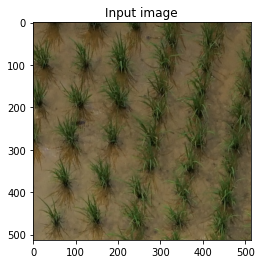

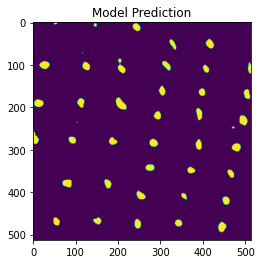

In [15]:
prediction = eval_one_testing_image(model, img_name=_img_names[0], num_class=2, \
                            crop_size=(513,513), crop_origin=(0,0), test_folder=test_folder)